In [1]:
"""
Reproduction code for
`Geometric Dynamics of Signal Propagation Predict Trainability of Transformers`
Aditya Cowsik • Tamra Nebabu • Xiao-Liang Qi • Surya Ganguli (arXiv:2403.02579)

Reproducing phase–diagram of the gradient Lyapunov exponent  λ_g (Figure 5)
===================================================

λ_g is defined as
    λ_g = (1/L) · log ‖∂/∂x₀ ⟨R, x_L⟩‖₂
with   L = 16  transformer layers
       R ~ N(0,I)   (new for every evaluation)

Grid:
    α       : 100 points in [0, 1]
    σ_w     : 100 points in [1, 4]
Averaging:
    n_init   number of random-weight initializations
    n_tokens number of random tokens per trial

"""
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

torch.set_default_dtype(torch.float64)

# ────────────────────────────────────────────────────────────────────────────
# Transformer layer
# ────────────────────────────────────────────────────────────────────────────
class OneHeadLayer(nn.Module):
    """Single layer exactly matching the paper’s architecture."""
    def __init__(self, d: int, sigma_A: float, sigma_w: float,
                 alpha_A: float, alphatilde_A: float,
                 alpha_M: float, alphatilde_M: float, device="cuda"):
        super().__init__()
        self.d = d
        self.alpha_A = alpha_A
        self.alphatilde_A = alphatilde_A
        self.alpha_M = alpha_M
        self.alphatilde_M = alphatilde_M

        # Gaussian initializations with variances described in Sec. 2
        self.Q = torch.randn(d, d, device=device) / math.sqrt(d)
        self.K = torch.randn(d, d, device=device) / math.sqrt(d) * sigma_A
        self.V = torch.randn(d, d, device=device) / math.sqrt(d)
        self.W0 = torch.randn(d, d, device=device) / math.sqrt(d) * sigma_w
        self.W1 = torch.randn(d, d, device=device) / math.sqrt(d) * sigma_w

    def layer_norm_tokens(self, x: torch.Tensor) -> torch.Tensor:
        """
        Tokenwise LayerNorm without learned gain/bias (Eq. 3).
        """
        return x / (x.norm(dim=-1, keepdim=True) + 1e-9) * math.sqrt(self.d)

    def attention_block(self, x: torch.Tensor) -> torch.Tensor:
        """
        Single-head self-attention with residual weights α and α̃ (Eq. 4, first line).
        Shapes
        -------
        x : (batch=n, d)
        Q, K : (d, d)   — shared across tokens in the layer
        V     : (d, d)
        Returns: (batch, d)
        """
        y = self.layer_norm_tokens(x)                       # (n, d)
        attn_scores = (y @ self.Q).matmul((y @ self.K).T) / math.sqrt(self.d)  # (n, n)
        A = torch.softmax(attn_scores, dim=-1)                            # (n, n)
        attn_out = A @ (y @ self.V)                                            # (n, d)
        return self.alphatilde_A * x + self.alpha_A * attn_out                          # residual
    
    
    def mlp_block(self, x: torch.Tensor) -> torch.Tensor:
        """
        Two-layer tanh MLP with residual (Eq. 2 + Eq. 4, second line).
        """
        y = self.layer_norm_tokens(x)
        hidden = torch.tanh(y @ self.W0)
        out    = torch.tanh(hidden @ self.W1)
        return self.alphatilde_M * x + self.alpha_M * out                              # residual

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.attention_block(x)
        x = self.mlp_block(x)
        return x


def build_transformer(L: int, d: int, 
                      sigma_A: float, sigma_w: float, 
                      alpha_A: float, alphatilde_A: float, 
                      alpha_M: float, alphatilde_M: float, 
                      device = 'cuda'):
    """Stack L identical OneHeadLayer objects (no weight sharing)."""
    return nn.ModuleList([
        OneHeadLayer(d=d, sigma_A=sigma_A, sigma_w=sigma_w, 
                     alpha_A=alpha_A, alphatilde_A=alphatilde_A, 
                     alpha_M=alpha_M, alphatilde_M=alphatilde_M,
                     device=device)
        for _ in range(L)
    ])


In [2]:
# ---------------------------------------------------------------------
# 1)  Correlated–but–coordinate–wise-independent token sampler
# ---------------------------------------------------------------------
@torch.no_grad()
def sample_correlated_tokens(d: int,
                             n: int,
                             cos_theta: float = .99,
                             device: str = "cuda") -> torch.Tensor:
    """
    Returns an (n, d) tensor whose rows X_i satisfy
        E[X_i·X_i]       = d
        E[X_i·X_j]       = cos_theta * d    (i≠j)
        Cov((X_i)_a,(X_j)_b) = 0 for a≠b, ∀ i,j

    Construction
    ------------
    For each coordinate k=1…d draw a *shared* latent g_k ~ N(0,1).
    For each token i draw an independent η_{ik} ~ N(0,1).
        X_{ik} = √cos_theta · g_k + √(1−cos_theta) · η_{ik}.
    Coordinates are independent because g_k and η_{ik} vary with k.
    """
    g   = torch.randn(d,               device=device)            # shared across tokens
    eta = torch.randn(n, d,           device=device)             # independent noise
    x   = math.sqrt(cos_theta) * g + math.sqrt(1. - cos_theta) * eta   # broadcast add
    return x        # no layer-norm ⇒ coordinate-wise independence preserved

# ---------------------------------------------------------------------
# 2)  λ_g estimator that uses the sampler above
# ---------------------------------------------------------------------
def estimate_lambda_g(transformer, 
             d: int,
             n: int,
             cos_init: float = .99,
             device: str = "cuda") -> float:
    """
    Compute λ_g for *one* weight initialisation and *one* token set.
    transformer : ModuleList of length L
    x0          : (n, d) tokens   (requires_grad=False)
    """
    x0 = sample_correlated_tokens(d, n, cos_init, device).requires_grad_(True)        # (n, d)
    
    x = x0.clone().requires_grad_(True)
    for layer in transformer:
        x = layer(x)

    R = torch.randn_like(x)             # random read-out
    scalar = (x * R).sum()
    grad   = torch.autograd.grad(scalar, x0)[0]

    # denominator: ‖∂_{X0} ⟨X0, R⟩‖²  =  ‖R‖²
    num   = torch.sum(grad**2)
    denom = torch.sum(R**2)
    
    L = len(transformer)
    return (torch.log(num / denom) / L).cpu().item()     # plain Python float
    

In [3]:
# ────────────────────────────────────────────────────────────────────────
# 3.  Averaging helper
# ────────────────────────────────────────────────────────────────────────
def mean_lambda_g(L: int, d: int, n_tokens: int,
                  alpha_A: float, alpha_M: float, 
                  sigma_w: float, sigma_A: float,
                  n_init: int,
                  device: str = "cuda") -> float:
    """Average λ_a over random weights *and* random token clouds."""
    vals = []
    for _ in range(n_init):
        # new layer  → new weights
        alphatilde_A = math.sqrt(max(1.0 - alpha_A**2, 0.0))
        alphatilde_M = math.sqrt(max(1.0 - alpha_M**2, 0.0))
        transformer = build_transformer(
            L=L, d=d, 
            sigma_A=sigma_A, sigma_w=sigma_w, 
            alpha_A=alpha_A, alphatilde_A=alphatilde_A, 
            alpha_M=alpha_M, alphatilde_M=alphatilde_M, 
            device=device).eval()
        # new input cloud
        vals.append(estimate_lambda_g(transformer, d=d, n=n_tokens, device=device))
    return float(np.mean(vals))

lambda_a phase diagram I (sigma_W vs. alpha)

In [5]:
L = 16
d = 64
n_tokens = 256
n_init = 10
sigma_A = 1.
device = 'cuda'    # 'cpu' if cuda is not available

# --- parameter grids (100 × 100) ------------------------------------
alphas  = np.linspace(0.0, 1.0, 100)   # 0 ≤ α ≤ 1   (100 pts)
sigmasw = np.linspace(1.0, 4.0, 100)   # 1 ≤ σ_w ≤ 4 (100 pts)
grid    = np.empty((len(sigmasw), len(alphas)), dtype=np.float64)

for i, sigma_w in enumerate(tqdm(sigmasw, desc="σ_w loop")):
    for j, alpha in enumerate(alphas):
        grid[i, j] = mean_lambda_g(
            L=L, d=d, n_tokens=n_tokens,
            alpha_A=alpha, alpha_M=alpha, 
            sigma_w=sigma_w, sigma_A=sigma_A,
            n_init=n_init, 
            device=device
        )


σ_w loop: 100%|██████████| 100/100 [11:55<00:00,  7.16s/it]


<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_25054/242916659.py:25: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"Numerical $\lambda_g$ (alpha_A=alpha_M, $\sigma_A=${sigma_A:.1f})", fontsize=20, pad=12)


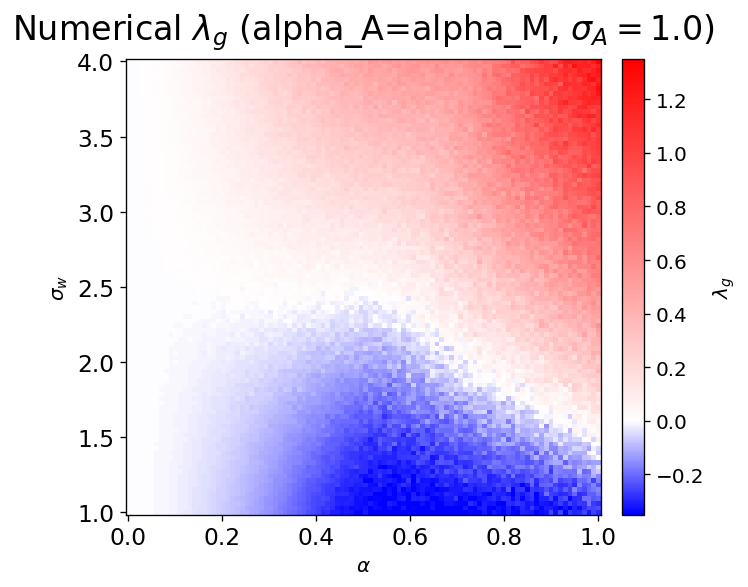

In [6]:
# ── heat-map with bwr, linear colour-bar, white at 0 ──────────────────────
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

A, S = np.meshgrid(alphas, sigmasw)

vmin, vmax = -.35, 1.35                           # data limits
norm  = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

mid   = abs(vmin) / (vmax - vmin)               # fractional position of zero
base  = plt.get_cmap("bwr")                     # <<< changed only this line
cmap  = mpl.colors.LinearSegmentedColormap.from_list(
           "shifted_bwr",
           [(0.0, base(0.0)),                   # deepest blue
            (mid, base(0.5)),                  # pure white at value 0
            (1.0, base(1.0))],                 # deepest red
           N=256)

fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
pcm = ax.pcolormesh(A, S, grid, cmap=cmap, norm=norm, shading="auto")

ax.set_xlabel(r"$\alpha$", fontsize=12)
ax.set_ylabel(r"$\sigma_w$", fontsize=12)
ax.set_title(f"Numerical $\lambda_g$ (alpha_A=alpha_M, $\sigma_A=${sigma_A:.1f})", fontsize=20, pad=12)
ax.tick_params(axis='both', which='major', labelsize=14)

cbar = fig.colorbar(pcm, ax=ax, fraction=0.045, pad=0.04)
cbar.set_label(r"$\lambda_g$", fontsize=12)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

fig.savefig(f"lambda_g_phase_diagram_alpha_sA{sigma_A:.1f}.pdf", format="pdf")   # or give a full path

lambda_a phase diagram II (alpha_A vs. alpha_M)

In [8]:
L = 16
d = 64
n_tokens = 256
n_init = 10
sigma_A = 1.
sigma_w = 2.
device = 'cuda'    # 'cpu' if cuda is not available

# --- parameter grids (100 × 100) ------------------------------------
alphaAs  = np.linspace(0.0, 1.0, 100)   # 0 ≤ α ≤ 1   (100 pts)
alphaMs  = np.linspace(0.0, 1.0, 100)   # 0 ≤ α ≤ 1   (100 pts)
grid    = np.empty((len(sigmasw), len(alphas)), dtype=np.float64)

for i, alpha_A in enumerate(tqdm(alphaAs, desc="alpha_A loop")):
    for j, alpha_M in enumerate(alphaMs):
        grid[i, j] = mean_lambda_g(
            L=L, d=d, n_tokens=n_tokens,
            alpha_A=alpha_A, alpha_M=alpha_M, 
            sigma_w=sigma_w, sigma_A=sigma_A,
            n_init=n_init, 
            device=device
        )


alpha_A loop: 100%|██████████| 100/100 [11:54<00:00,  7.15s/it]


<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_25054/2479689001.py:25: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"Numerical $\lambda_g$ ($\sigma_w=${sigma_w:.1f}, $\sigma_A=${sigma_A:.1f})", fontsize=20, pad=12)
/tmp/ipykernel_25054/2479689001.py:25: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title(f"Numerical $\lambda_g$ ($\sigma_w=${sigma_w:.1f}, $\sigma_A=${sigma_A:.1f})", fontsize=20, pad=12)


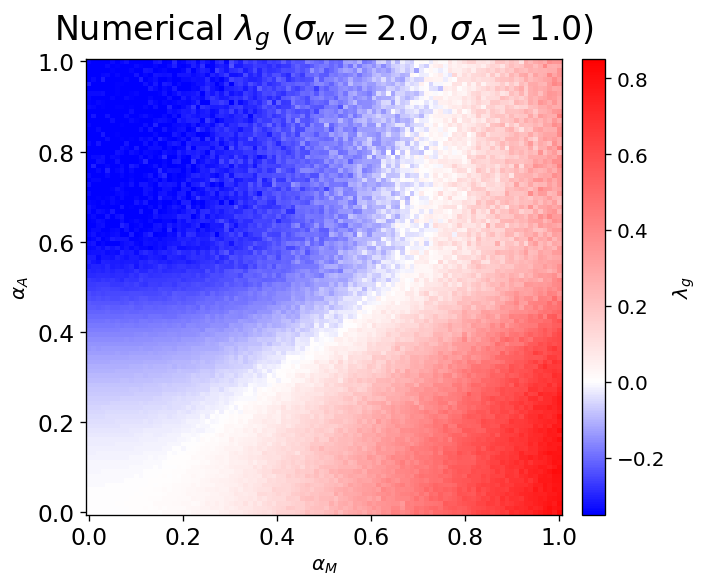

In [9]:
# ── heat-map with bwr, linear colour-bar, white at 0 ──────────────────────
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

A_M, A_A = np.meshgrid(alphaMs, alphaAs)

vmin, vmax = -.35, 0.85                           # data limits
norm  = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

mid   = abs(vmin) / (vmax - vmin)               # fractional position of zero
base  = plt.get_cmap("bwr")                     # <<< changed only this line
cmap  = mpl.colors.LinearSegmentedColormap.from_list(
           "shifted_bwr",
           [(0.0, base(0.0)),                   # deepest blue
            (mid, base(0.5)),                  # pure white at value 0
            (1.0, base(1.0))],                 # deepest red
           N=256)

fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
pcm = ax.pcolormesh(A_M, A_A, grid, cmap=cmap, norm=norm, shading="auto")

ax.set_xlabel(r"$\alpha_M$", fontsize=12)
ax.set_ylabel(r"$\alpha_A$", fontsize=12)
ax.set_title(f"Numerical $\lambda_g$ ($\sigma_w=${sigma_w:.1f}, $\sigma_A=${sigma_A:.1f})", fontsize=20, pad=12)
ax.tick_params(axis='both', which='major', labelsize=14)

cbar = fig.colorbar(pcm, ax=ax, fraction=0.045, pad=0.04)
cbar.set_label(r"$\lambda_g$", fontsize=12)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

fig.savefig(f"lambda_g_phase_diagram_sw{sigma_w:.1f}_sA{sigma_A:.1f}.pdf", format="pdf")   # or give a full path